In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

C:\Users\pzns1\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preprocessing

In [3]:
data = pd.read_csv('credit_score.csv')
data = data.drop(columns=['Unnamed: 0'])
data.head(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [4]:
data.shape

(1000, 9)

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
Job,1000.0,1.904,0.653614,0.0,2.0,2.0,2.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [7]:
data.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64

#### Check for missed data and fill it

In [8]:
data['Saving accounts'] = data['Saving accounts'].fillna('unk')
data['Checking account'] = data['Checking account'].fillna('unk')
data.head(3)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,unk,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,unk,2096,12,education


#### Make categorial features

In [9]:
categorial_features = ['Sex', 'Housing', 'Checking account', 'Purpose']
order = [['unk', 'little', 'moderate', 'quite rich', 'rich']]

#### Code categorial data to numeric vectors for model implementation

In [10]:
oe = OrdinalEncoder(categories=order)
data['Saving accounts'] = oe.fit_transform(data[['Saving accounts']])

In [11]:
ohe = OneHotEncoder(handle_unknown='ignore')
encoded = ohe.fit_transform(data[categorial_features]).toarray()

In [12]:
encoded_data = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(categorial_features))
data = pd.concat([data, encoded_data], axis=1).drop(categorial_features, axis=1)
data.head(7)

,Age,Job,Saving accounts,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,...,Checking account_rich,Checking account_unk,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,2,0.0,1169,6,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,22,2,1.0,5951,48,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,49,1,1.0,2096,12,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,45,2,1.0,7882,42,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,53,2,1.0,4870,24,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,35,1,0.0,9055,36,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,53,2,3.0,2835,24,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Let's look at age, credit amount, credit duration distributions and features correlation

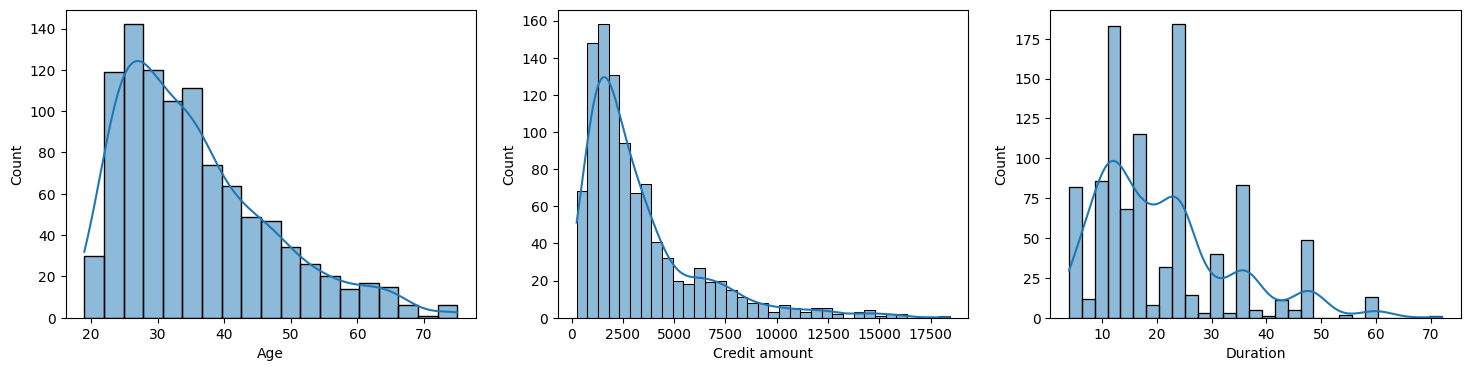

In [13]:
subplot_name = ['Age', 'Credit amount', 'Duration']

n = 1
indx = 0

plt.figure(figsize=(18, 4))

for i in range(3):
    plt.subplot(1, 3, n)
    sns.histplot(x=data[subplot_name[indx]], kde=True)

    n += 1
    indx += 1

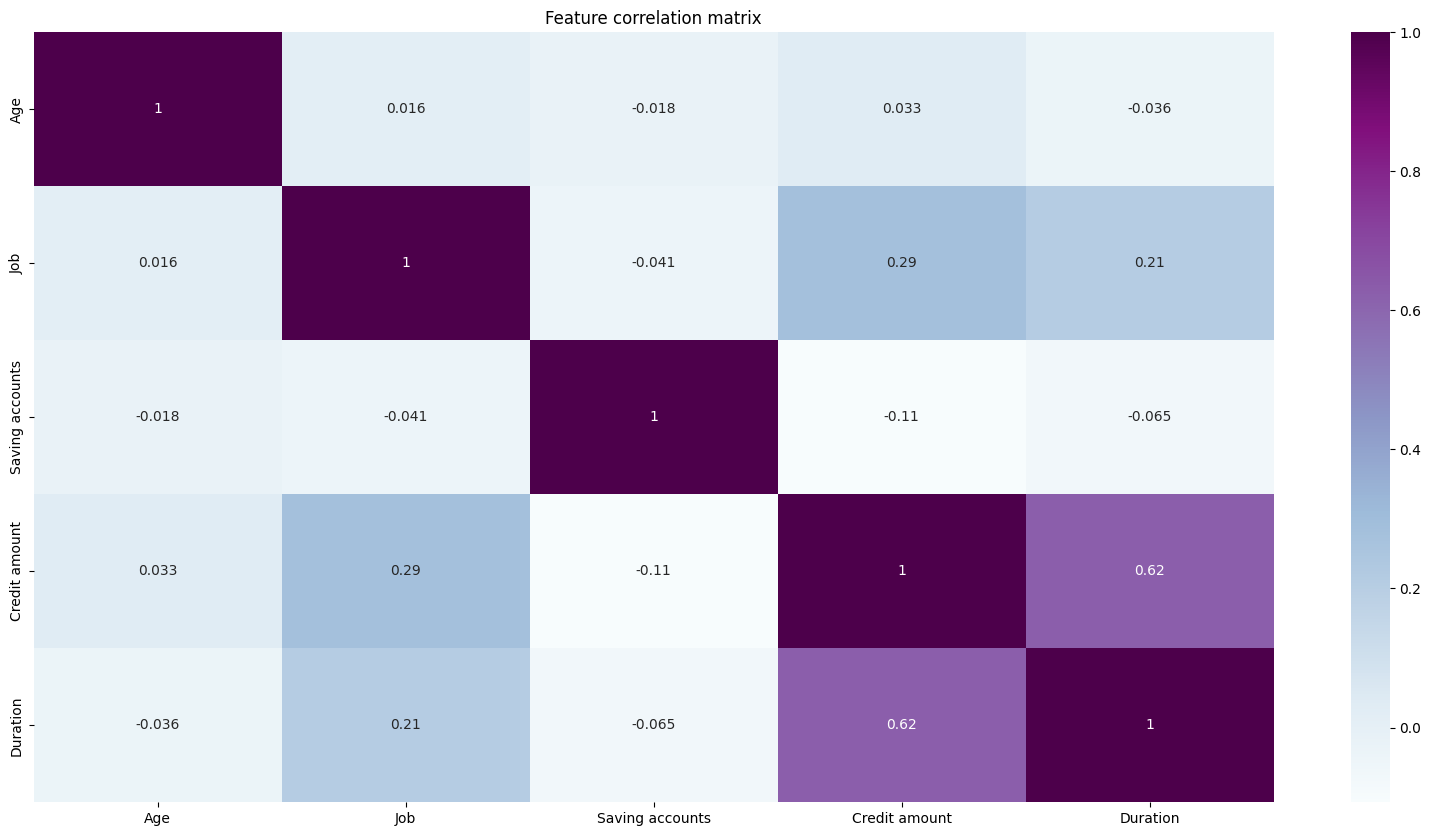

In [14]:
data_corr = data.drop(columns = ohe.get_feature_names_out(categorial_features))
plt.figure(figsize=(20, 10))
sns.heatmap(data_corr.corr(), annot=True, cmap='BuPu')
plt.title('Feature correlation matrix')
plt.show()

## Divide to features and targets

#### переделай выбор и категоризацию засчёт подсчёта долговой нагрузки, добавления рандомных зарплат в каком-то диапазоне для категорий бедности и потом переобучи модель

In [54]:
X = data.drop(columns=['Credit amount'])
y = ((data['Credit amount'] < threshold) & (data['Income'] > certain_value))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

In [55]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 

## Random forest

### Hyperparameter picking

In [56]:
estimators = [10, 50, 100, 300, 400, 500, 600]
min_samples_leaf = list(np.arange(1, 20, 5))
max_depth = list(np.arange(1, 5, 1))

grid_values = {'n_estimators': estimators, 'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}

In [57]:
clf = GridSearchCV(RandomForestClassifier(), grid_values, scoring='roc_auc', cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [np.int64(1), np.int64(2), np.int64(3),
                                       np.int64(4)],
                         'min_samples_leaf': [np.int64(1), np.int64(6),
                                              np.int64(11), np.int64(16)],
                         'n_estimators': [10, 50, 100, 300, 400, 500, 600]},
             scoring='roc_auc')

In [142]:
best_n_estimators_value = clf.best_params_['n_estimators']
best_min_samples_leaf = clf.best_params_['min_samples_leaf']
best_max_depth = clf.best_params_['max_depth']
best_score = clf.best_score_

print('Optimal trees amount: ', best_n_estimators_value)
print('Optimal leaves amount: ', best_min_samples_leaf)
print('Optimal depth: ', best_max_depth)
print('ROC-AUC: ', best_score)

Optimal trees amount:  600
Optimal leaves amount:  1
Optimal depth:  4
ROC-AUC:  0.8227952479676264


In [68]:
model = RandomForestClassifier(n_estimators=best_n_estimators_value,
                               max_depth=best_max_depth,
                               min_samples_leaf=best_min_samples_leaf,
                               random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

## Shapley value

In [138]:
sample_idx = 0

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)
# shap.plots.waterfall(shap_values[0][0][0])
type(shap_values)

shap._explanation.Explanation

### Quality check

In [141]:
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC score: {roc_auc}')

ROC-AUC score: 0.743175431553593


In [146]:
importances = model.feature_importances_
features = pd.DataFrame({"feature": X.columns, 'importance': importances})
features.sort_values(by = 'importance', ascending = False)

,feature,importance
3,Duration,0.549640
1,Job,0.115303
0,Age,0.052622
18,Purpose_radio/TV,0.047485
2,Saving accounts,0.025341
4,Sex_female,0.021358
6,Housing_free,0.019814
10,Checking account_moderate,0.018684
11,Checking account_rich,0.018181
5,Sex_male,0.017761


In [152]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print('')
print("Confusion Matrix:")
print(conf_matrix)
print('')
print("Classification Report:")
print(class_report)

Accuracy: 0.745

Confusion Matrix:
[[82 24]
 [27 67]]

Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.77      0.76       106
        True       0.74      0.71      0.72        94

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.74      0.74      0.74       200



# 

## GradBoost Classifier

### Hyperparameter picking

In [154]:
estimators = [10, 50, 100, 300, 400, 500, 600]
min_samples_leaf = list(np.arange(1, 20, 5))
max_depth = list(np.arange(1, 10, 3))

grid_values = {'n_estimators': estimators, 'min_samples_leaf': min_samples_leaf, 'max_depth': max_depth}

In [155]:
clf = GridSearchCV(GradientBoostingClassifier(), grid_values, scoring='roc_auc', cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [np.int64(1), np.int64(4), np.int64(7)],
                         'min_samples_leaf': [np.int64(1), np.int64(6),
                                              np.int64(11), np.int64(16)],
                         'n_estimators': [10, 50, 100, 300, 400, 500, 600]},
             scoring='roc_auc')

In [157]:
best_n_estimators_value_boost = clf.best_params_['n_estimators']
best_min_samples_leaf_boost = clf.best_params_['min_samples_leaf']
best_max_depth_boost = clf.best_params_['max_depth']
best_score_boost = clf.best_score_

In [159]:
print('Optimal trees amount: ', best_n_estimators_value_boost)
print('Optimal leaves amount: ', best_min_samples_leaf_boost)
print('Optimal depth: ', best_max_depth_boost)
print('ROC-AUC: ', best_score_boost)

Optimal trees amount:  100
Optimal leaves amount:  6
Optimal depth:  1
ROC-AUC:  0.8283911915176709


In [160]:
gb_clf = GradientBoostingClassifier(n_estimators=best_n_estimators_value_boost,
                                    learning_rate=0.1,
                                    min_samples_leaf=best_min_samples_leaf_boost,
                                    max_depth=best_max_depth_boost,
                                    random_state=42)
gb_clf.fit(X_train, y_train)

y_pred = gb_clf.predict(X_test)

## Shapley value

## Quality check

In [161]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print('')
print("Confusion Matrix:")
print(conf_matrix)
print('')
print("Classification Report:")
print(class_report)

Accuracy: 0.77

Confusion Matrix:
[[90 16]
 [30 64]]

Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.85      0.80       106
        True       0.80      0.68      0.74        94

    accuracy                           0.77       200
   macro avg       0.78      0.76      0.77       200
weighted avg       0.77      0.77      0.77       200

